In [5]:
import logging
import os
import sys
import datetime

sys.path.append("..")

import gc
import json
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.models as models

from diffusers import DDIMScheduler
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Lambda
from IPython.display import clear_output
from tqdm import trange

from src import distributions
from src.mnistm_utils import MNISTM
from src.guided_samplers import PairedSubsetSampler, SubsetGuidedDataset, get_indicies_subset

from src.cunet import CUNet
from src.enot import SDE, integrate
from src.resnet2 import ResNet_D

from src.new_plotters import plot_fixed_linked_sdes_images, plot_random_linked_sdes_images

from src.tools import freeze, unfreeze, weights_init_D


%matplotlib inline

In [6]:
gc.collect()
torch.cuda.empty_cache()

## Plot Utils

In [7]:
from src.guided_samplers import Sampler, PairedSubsetSampler


class PairedPlotSampler(Sampler):
    def __init__(self, loader, subsetsize = 8, weight=None, device='cuda'):
        super(PairedPlotSampler, self).__init__(device)
        self.loader = loader
        self.subsetsize = subsetsize
        if weight is None:
            weight = [1/self.loader.num_classes for _ in range(self.loader.num_classes)]
        self.weight = weight
        
    def sample(self):
        classes = np.array(list(range(0,10)))
        batch_X = []
        batch_Y = []
        with torch.no_grad():
            for class_ in classes: 
                X, Y = self.loader.get(class_, self.subsetsize)
                batch_X.append(X.clone().to(self.device).float())
                batch_Y.append(Y.clone().to(self.device).float())
        return torch.stack(batch_X).to(self.device), torch.stack(batch_Y).to(self.device)

In [19]:
from src.fid_score import calculate_frechet_distance
from src.tools import compute_transport_accuracy, get_linked_sdes_pushed_loader_stats, linked_mapping


def plot_transport_results(X, Y, SDEs, m_data=None, s_data=None, XY_test_sampler=None, classifier=None, metrics=False):
    FID = []
    accuracies = []
    fig, axes = plt.subplots(3, 10, figsize=(9, 3.5), dpi=150)
    axes[0, 0].set_ylabel('$x \sim \mathbb{P}_n$', fontsize=18)
    axes[1, 0].set_ylabel('$y \sim \mathbb{Q}_n$', fontsize=18)
    images = [X, Y]
    labels = ['$\mathcal{F}_{G}$ \n (ours)', '$\mathcal{F}_{G}$ \n (ours)']
    
    for sde in SDEs:
        freeze(sde)
    
    with torch.no_grad():
        T_X = linked_mapping(SDEs, X)
        images.append(T_X)
    axes[2, 0].set_ylabel("{}".format(labels[0]), fontsize=20)
    
    if metrics:
        print('Method: DiffOT')
        print('Calculating ACC')
        accuracy = compute_transport_accuracy(SDEs, XY_test_sampler,
                                               100, classifier)
        print(f"Accuracy: {accuracy}")
        print('Calculating FID')
        mu, sigma = get_linked_sdes_pushed_loader_stats(SDEs, XY_test_sampler, 
                                                  inception=True, size=10000, batch_size=100, verbose=True
                                                  )
        fid = calculate_frechet_distance(m_data, s_data, mu, sigma)
        print(f"FID: {fid}")
        FID.append(fid)
        accuracies.append(accuracy)
            
    x_titles = [0,1,2,3,4,5,6,7,8,9]
    for i, title in enumerate(x_titles):
        axes[0,i].set_title(r'${}$'.format(title), fontsize=20)
    imgs = torch.cat(images).to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i], cmap='Greys')
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
    
    fig.tight_layout(pad=0.001)
    plt.show()
    return FID, accuracies, fig

## Init Parameters

In [9]:
DEVICE_IDS = [0]

NUM_LABELED = 10
SUBSET_WEIGHTS = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
DATASET = 'fmnist2mnist'
DATASET_PATH = '~/data/'
IMG_SIZE = 32
CHANNELS = 1


In [10]:
# change below 3 variables to get real EXP_NAME
STRATEGY = "Adapt"  # [Normal|Fix|Adapt]
PIVOTAL_LIST = [0, 20, 50, 100]
TIME = "20240606-200021" # "20240526-134124"

EXP_NAME = f"{STRATEGY}_{DATASET}_pivotal_{'_'.join(map(str, PIVOTAL_LIST))}_{TIME}"
LOAD_PATH = f"../logs/{EXP_NAME}/"

print(f"{EXP_NAME = }")

# LOAD_PATH = "../logs/weights/epl_1/"
print(f"{LOAD_PATH = }")


with open(os.path.join(LOAD_PATH, "config.json"), "r", encoding="utf-8") as f:
    CONFIG = json.load(f)


EXP_NAME = 'Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021'
LOAD_PATH = '../logs/Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021/'


In [11]:
EPSILON = CONFIG["EPSILON"]

N_STEPS = CONFIG["N_STEPS"]
# SUBSET_WEIGHTS = CONFIG["SUBSET_WEIGHTS"]
BATCH_SIZE = CONFIG["BATCH_SIZE"]
SUBSET_SIZE = CONFIG["SUBSET_SIZE"]
DIFFUSION_STEPS = CONFIG["DIFFUSION_STEPS"]
PIVOTAL_LIST = CONFIG["PIVOTAL_LIST"]
OUTER_ITERS = CONFIG["OUTER_ITERS"]


IMG_SIZE = CONFIG["IMG_SIZE"]
UNET_BASE_FACTOR = CONFIG["UNET_BASE_FACTOR"]

TIME_DIM = CONFIG["TIME_DIM"]
USE_POSITIONAL_ENCODING = CONFIG["USE_POSITIONAL_ENCODING"]

PREDICT_SHIFT = CONFIG["PREDICT_SHIFT"]

USE_GRADIENT_CHECKPOINT = CONFIG["USE_GRADIENT_CHECKPOINT"]
N_LAST_STEPS_WITHOUT_NOISE = CONFIG["N_LAST_STEPS_WITHOUT_NOISE"]
IMAGE_INPUT = CONFIG["IMAGE_INPUT"]
FID_EPOCHS = CONFIG["FID_EPOCHS"]

SEED = CONFIG["SEED"]
assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")
torch.manual_seed(SEED)
np.random.seed(SEED)

## Upload data for plot, accuracy, and FID

### initalize data sampler


In [12]:
source_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9])
new_labels_source = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
target_subset = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
new_labels_target = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}

In [13]:
classifier = models.resnet18()

source_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)), 
    ToTensor(),
    Normalize((0.5), (0.5)),
])
target_transform = source_transform

if DATASET == 'mnist2kmnist':
    source = datasets.MNIST
    target = datasets.KMNIST
    NC = 1
    classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/kmnist.pt'))

elif DATASET == 'fmnist2mnist':
    source = datasets.FashionMNIST
    target = datasets.MNIST
    NC = 1
    classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/mnist.pt'))

    
elif DATASET == 'mnist2usps':
    source = datasets.MNIST
    target = datasets.USPS
    NC = 1
    classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/usps.pt'))
    

elif DATASET == 'mnist2mnistm':
    source = datasets.MNIST
    target = MNISTM
    NC = 3
    classifier.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    classifier.load_state_dict(torch.load('../saved_models/classifiers/mnistm.pt'))
    source_transform = Compose([
        Resize((IMG_SIZE, IMG_SIZE)), 
        ToTensor(),
        Normalize((0.5), (0.5)), 
        Lambda(lambda x: -x.repeat(3,1,1))])
    target_transform = Compose([
        Resize(IMG_SIZE),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classifier.cuda()
classifier.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
from src.tools import get_loader_stats
from src.guided_samplers import PairedSubsetSampler

source_test = source(root=DATASET_PATH, train=False, download=True, transform=source_transform)
source_test_subset_samples, labels, source_class_indicies = get_indicies_subset(source_test, 
                                                                    new_labels =new_labels_source,
                                                                    classes=len(source_subset), 
                                                                    subset_classes=source_subset)
source_test =  torch.utils.data.TensorDataset(torch.stack(source_test_subset_samples), torch.LongTensor(labels))


target_test = target(root=DATASET_PATH, train=False, download=True, transform=target_transform)  
target_test_subset_samples, target_labels, target_class_indicies = get_indicies_subset(target_test, 
                                                                                  new_labels = new_labels_target, 
                                                                                  classes=len(target_subset), 
                                                                                  subset_classes=target_subset)
target_test = torch.utils.data.TensorDataset(torch.stack(target_test_subset_samples), torch.LongTensor(target_labels))


full_set = SubsetGuidedDataset(source_test, target_test, num_labeled='all', in_indicies = source_class_indicies, out_indicies = target_class_indicies)


XY_test_sampler = PairedSubsetSampler(full_set, subsetsize=1, weight=SUBSET_WEIGHTS)

m_data, s_data = get_loader_stats(XY_test_sampler, inception=True, use_Y=True, size=10000, batch_size=100, verbose=True)

m_data.shape, s_data.shape

100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


((2048,), (2048, 2048))

### initialize models


In [15]:
from src.tools import weights_init_D

from src.cunet import CUNet
from src.enot import SDE
from src.resnet2 import ResNet_D

SDEs, BETA_NETs = [], []
SDE_OPTs, BETA_NET_OPTs = [], []
SDE_SCHEDULERs, BETA_NET_SCHEDULERs = [], []

for i in range(len(PIVOTAL_LIST) * 2 - 2):
    sde = CUNet(
        CHANNELS, CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR
    ).cuda()

    sde = SDE(
        shift_model=sde,
        epsilon=EPSILON,
        n_steps=N_STEPS,
        time_dim=TIME_DIM,
        n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
        use_positional_encoding=USE_POSITIONAL_ENCODING,
        use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
        predict_shift=PREDICT_SHIFT,
        image_input=IMAGE_INPUT,
    ).cuda()
    SDEs.append(sde)

    beta_net = ResNet_D(IMG_SIZE, nc=CHANNELS).cuda()
    beta_net.apply(weights_init_D)
    BETA_NETs.append(beta_net)


if len(DEVICE_IDS) > 1:
    for i in range(len(SDEs)):
        SDEs[i] = nn.DataParallel(SDEs[i], device_ids=DEVICE_IDS)
        BETA_NETs[i] = nn.DataParallel(BETA_NETs[i], device_ids=DEVICE_IDS)

        print("T params:", np.sum([np.prod(p.shape) for p in SDEs[0].parameters()]))
        print(
            "D params:", np.sum([np.prod(p.shape) for p in BETA_NETs[0].parameters()])
        )

#### load weights


In [16]:
# CKPT_DIR = os.path.join(LOAD_PATH, "iter5000/")
CKPT_DIR = LOAD_PATH
for i, sde in enumerate(SDEs):
    path = os.path.join(CKPT_DIR, f"sde{i}.pt")
    print(f"{path = }")
    sde.load_state_dict(torch.load(path))

path = '../logs/Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021/sde0.pt'
path = '../logs/Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021/sde1.pt'
path = '../logs/Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021/sde2.pt'
path = '../logs/Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021/sde3.pt'
path = '../logs/Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021/sde4.pt'
path = '../logs/Adapt_fmnist2mnist_pivotal_0_20_50_100_20240606-200021/sde5.pt'


## Print results

### trans example


In [17]:
X_fixed, Y_fixed = XY_test_sampler.sample(10)
X_fixed, Y_fixed = X_fixed.flatten(start_dim=0, end_dim=1), Y_fixed.flatten(start_dim=0, end_dim=1)

Method: DiffOT
Calculating ACC
Accuracy of the network: 8.61
Accuracy: 8.61
Calculating FID


100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


FID: 80.580155958669


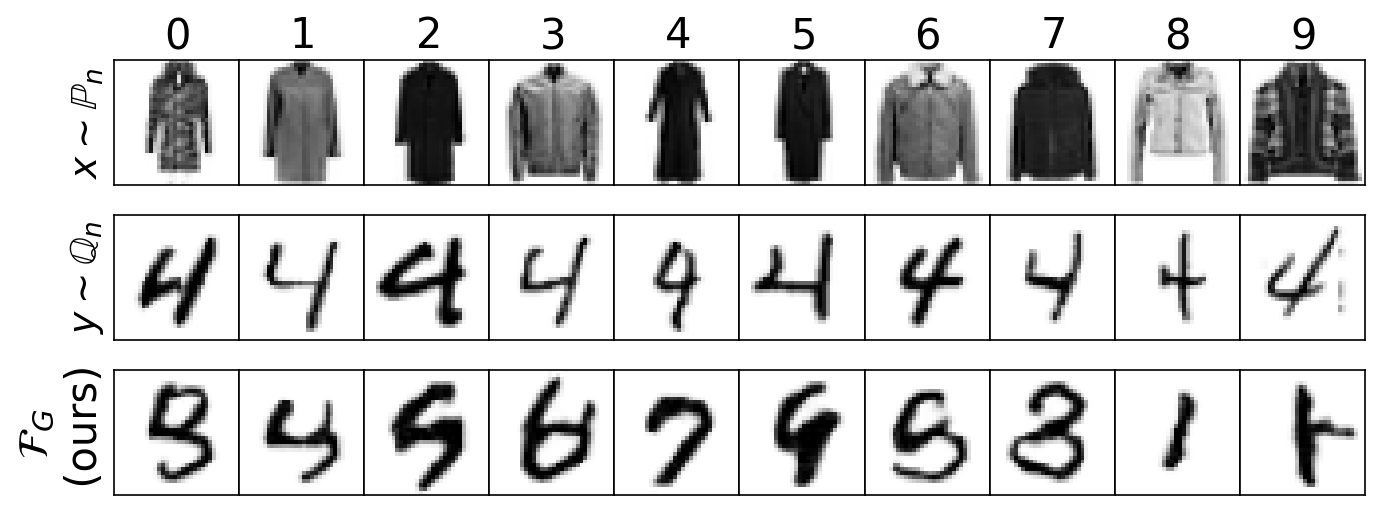

In [20]:
FID, accuracies, fig = plot_transport_results(X_fixed, 
                                              Y_fixed, 
                                              SDEs, 
                                              m_data,
                                              s_data,
                                              XY_test_sampler, 
                                              classifier,
                                              metrics=True)

## exp result logs

|Strategy|P List|Iteration|EPSILON|FID|
|---|---|---|---|---|
|Fix | 0 50 100 | 2000 | 0 | 32.893237846423915 |
|Adapt | 0 50 100 | 2000 | 0 | 46.39155850464904 |
|Fix | 0 50 100 | 5000 | 0 | 38.80040275352846 |
|Adapt | 0 20 50 100 | 2000 | 0 | 41.630040873129474|

### ACC

TODO:
